# Train with real data from Fluvius

## Read raw data

In [72]:
import os
from pathlib import Path
import pandas as pd
directory = Path.cwd()
##  You have to download the datal from the following link:
# https://opendata.fluvius.be/explore/dataset/1_50-verbruiksprofielen-dm-elek-kwartierwaarden-voor-een-volledig-jaar/information/

time_series_Consumption=pd.read_pickle(os.path.join(directory,'all_time_series_Consumption.pkl'))
labels_df=pd.read_pickle(os.path.join(directory,'labels_df.pkl'))
time_series_Consumption.set_index('Datetime', inplace=True)
time_series_Consumption=time_series_Consumption.resample('h').sum()

#features_to_plot = [
#    ('mean', "Mean"),
#    ('std', "Standard Deviation"),
#    ('median', "Median"),
#    ('skew', "Skewness"),
#    ('sum', "Sum"),
#    ('min', "Minimum"),
#    ('max', "Maximum")]"

## Extract features

### Fuction for extarcting features
Featue engineering has been done in a seperate excerceis with a collection of scripts in the file named development.ipynb

In [73]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define a function to extract weekly and monthly features with prefixed row names and a single 'feature' column
def extract_time_features(df, freq, prefix):
    # Calculate statistics for each period individually
    mean = df.resample(freq).mean()
    mean.index = [f"{prefix}_mean_{i}" for i in range(len(mean))]
    
    std = df.resample(freq).std()
    std.index = [f"{prefix}_std_{i}" for i in range(len(std))]
    
    skew = df.resample(freq).apply(pd.Series.skew)
    skew.index = [f"{prefix}_skew_{i}" for i in range(len(skew))]
    
    sum_ = df.resample(freq).sum()
    sum_.index = [f"{prefix}_sum_{i}" for i in range(len(sum_))]
    
    max_ = df.resample(freq).max()
    max_.index = [f"{prefix}_max_{i}" for i in range(len(max_))]
    
    # Concatenate all features
    features = pd.concat([mean, std, sum_, skew, max_], axis=0) #min_,
    
    # Reset the index to have 'feature' as a column and IDs as columns
    features = features.reset_index()
    features = features.rename(columns={'index': 'feature'})
    
    return features


### Train, test and validation sets

In [74]:

# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(time_series_Consumption, 'W', 'W')
monthly_features = extract_time_features(time_series_Consumption, 'ME', 'M')
Annual_features = extract_time_features(time_series_Consumption, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)
# Step 1: Merge features and labels
data = pd.merge(combined_features_temp, labels_df[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X = data.drop(columns=['Category','ID'])
y = data['Category']

# seperate part of the data for validation 
X_org, X_valid,y_org, y_valid = train_test_split(X, y, test_size=0.2, random_state=80)

## Model training

### Hyper parameter optimization

In [85]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import joblib
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)

def model_trainer_advanced(X, y, algorithm='xgboost', param_distributions=None, save_model_path='best_model.joblib',label_encoder_Savepath='label_encoder.joblib'):
    """
    Train a model using refined hyperparameter tuning and cross-validation.
    
    Parameters:
    - X: pd.DataFrame, Feature matrix.
    - y: pd.Series or np.ndarray, Target labels.
    - algorithm: str, Algorithm to use ('xgboost' or 'random_forest').
    - param_distributions: dict, Hyperparameter distribution for RandomizedSearchCV.
    - save_model_path: str, Path to save the best model.

    Returns:
    - best_model: sklearn Pipeline, Best pipeline model.
    - label_encoder: sklearn.preprocessing.LabelEncoder, Encoder for labels.
    """
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X, y_encoded = smote.fit_resample(X, y_encoded)

    # Initialize Stratified K-Fold Cross-Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    best_accuracy = 0
    best_model = None

    # Define refined parameter distributions for RandomizedSearchCV
    if param_distributions is None:
        if algorithm == 'xgboost':
            param_distributions = {
                'learning_rate': [0.01, 0.05, 0.1, 0.2],
                'max_depth': [3, 5, 7, 9],
                'n_estimators': [50, 100, 200, 300],
                'subsample': [0.8, 0.9, 1.0],
                'colsample_bytree': [0.6, 0.8, 1.0],
                'gamma': [0, 0.1, 0.2, 0.3],
                'min_child_weight': [1, 3, 5],
                'reg_alpha': [0, 0.01, 0.1],
                'reg_lambda': [1, 1.5, 2]
            }
        elif algorithm == 'random_forest':
            param_distributions = {
                'n_estimators': [50, 100, 200, 300],
                'max_depth': [None, 10, 20, 30],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 4],
                'max_features': ['auto', 'sqrt', 'log2'],
                'bootstrap': [True, False]
            }

    # Cross-validation loop
    for fold, (train_index, test_index) in enumerate(skf.split(X, y_encoded)):
        print(f"\nStarting Fold {fold + 1}")
        
        # Split data
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y_encoded[train_index], y_encoded[test_index]

        # Define pipeline
        if algorithm == 'xgboost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
        elif algorithm == 'random_forest':
            model = RandomForestClassifier(random_state=42)
        else:
            raise ValueError("Unsupported algorithm. Choose 'xgboost' or 'random_forest'.")

        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Refined hyperparameter optimization
        random_search = RandomizedSearchCV(
            estimator=pipeline, # normalize the data
            param_distributions={'model__' + k: v for k, v in param_distributions.items()},
            scoring='accuracy',  # Customize scoring metric if needed
            cv=3,
            n_iter=50,  # Increased number of iterations
            n_jobs=-1,
            random_state=42,
            verbose=1
        )

        # Fit the random search
        random_search.fit(X_train, y_train)

        # Best model and metrics
        best_pipeline = random_search.best_estimator_
        y_pred = best_pipeline.predict(X_test)
        fold_accuracy = accuracy_score(y_test, y_pred)
        fold_f1 = f1_score(y_test, y_pred, average='weighted')
        fold_precision = precision_score(y_test, y_pred, average='weighted')
        fold_recall = recall_score(y_test, y_pred, average='weighted')

        print(f"Fold {fold + 1} Metrics:")
        print(f" - Accuracy: {fold_accuracy:.2f}")
        print(f" - F1-Score: {fold_f1:.2f}")
        print(f" - Precision: {fold_precision:.2f}")
        print(f" - Recall: {fold_recall:.2f}")

        # Check for best model
        if fold_accuracy > best_accuracy:
            best_accuracy = fold_accuracy
            best_model = best_pipeline

    # Save the best model
    joblib.dump(best_model, save_model_path)
    joblib.dump(label_encoder, save_model_path)
    print(f"\nBest Model Saved: {save_model_path}")
    print(f"Best Fold Accuracy: {best_accuracy:.2f}")

    return best_model, label_encoder


### Final model 

In [ ]:
# Train models on synthetic and real datasets
"""Avaialbe functions are: 
model_trainer, model_trainer_advanced, model_trainer_gridSearch
CHoose between XGBoost and Random Forest"""
algorithm='xgboost'  # or 'random_forest'
#model_synthetic, label_encoder_syn = model_trainer_advanced(X_trainTest_synthetic, y_trainTest_synthetic, algorithm=algorithm,  # or 'random_forest'
#    save_model_path='best_model_syntheticData.joblib')
model_real, label_encoder_real = model_trainer_advanced(X_org ,y_org,  algorithm=algorithm, #'xgboost' or 'random_forest'
    save_model_path='{algorithm}_realData.joblib',label_encoder_Savepath='{algorithm}_label_encoder_realData.joblib')


Starting Fold 1
Fitting 3 folds for each of 50 candidates, totalling 150 fits


### Visualization of the outcome

Overall Accuracy: 0.97

Classification Report:

              precision    recall  f1-score     support
0              1.000000  0.983051  0.991453   59.000000
1              0.947368  1.000000  0.972973   18.000000
2              1.000000  0.926471  0.961832   68.000000
3              0.934426  0.966102  0.950000   59.000000
4              0.932203  0.982143  0.956522   56.000000
accuracy       0.965385  0.965385  0.965385    0.965385
macro avg      0.962800  0.971553  0.966556  260.000000
weighted avg   0.966874  0.965385  0.965496  260.000000


C:\Users\SHARIFIM\AppData\Local\Temp\ipykernel_28776\3372242823.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=classification_report_df.index[:-3], y=classification_report_df['recall'][:-3], palette="viridis")


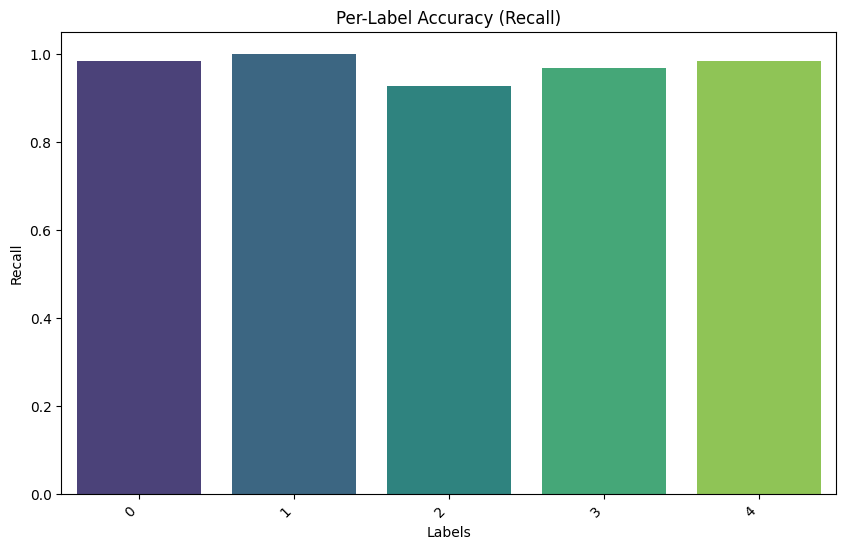

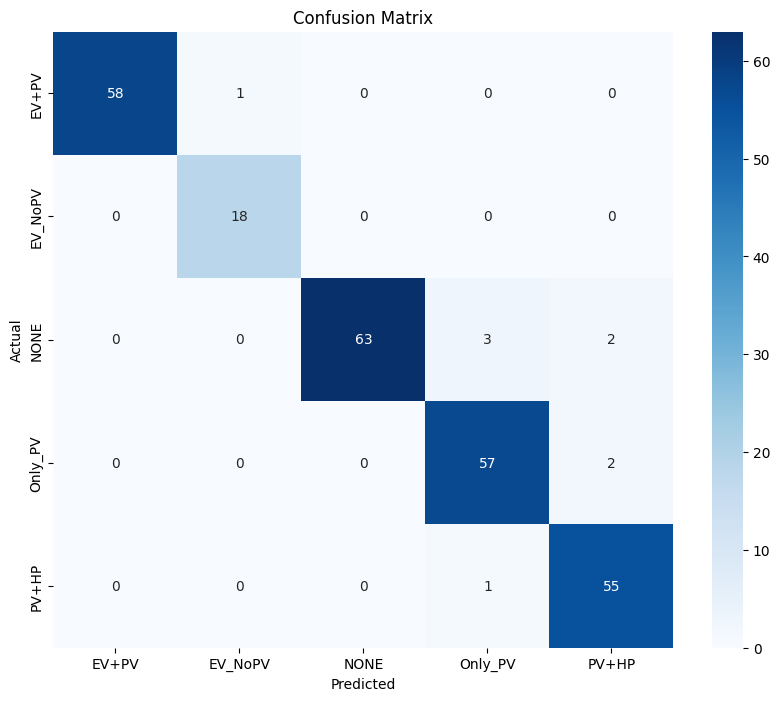

AttributeError: 'Pipeline' object has no attribute 'feature_importances_'

In [84]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Step 1: Make predictions using the best model

final_model = joblib.load('XGB_realData.joblib')  # Load the best model
label_encoder=joblib.load('xgb_label_encoder_realData.joblib')
###

y_pred = final_model.predict(X_valid)
y_valid_encoded=label_encoder.fit_transform(y_valid)

# Step 2: Calculate overall accuracy
overall_accuracy = accuracy_score(y_valid_encoded, y_pred)
print(f"Overall Accuracy: {overall_accuracy:.2f}")

# Step 3: Detailed classification report for per-label accuracy (precision, recall, F1-score for each label)
classification_report_dict = classification_report(y_valid_encoded, y_pred, output_dict=True)
classification_report_df = pd.DataFrame(classification_report_dict).transpose()

# Display per-label accuracy (recall for each label)
print("\nClassification Report:\n")
print(classification_report_df)

# Plot per-label accuracy (recall)
plt.figure(figsize=(10, 6))
sns.barplot(x=classification_report_df.index[:-3], y=classification_report_df['recall'][:-3], palette="viridis")
plt.title("Per-Label Accuracy (Recall)")
plt.xlabel("Labels")
plt.ylabel("Recall")
plt.xticks(rotation=45, ha="right")
plt.show()

# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_encoded, y_pred, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Feature Importance (Top 10)
# Get feature importances from the best model
feature_importances = final_model.feature_importances_
features = X_org.columns  # Assuming `X_train` has the original features
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance and select the top 10 features
top_10_importances = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_importances, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.show()


# Test the model on synthetic data

## syntehtic data with Labels

### pre-processing the input

In [57]:
import pandas as pd
##
###### These synthetic time series are generated by TUW and can be found in MODERATE project github.
syntehtic_timeSeries=pd.read_csv('fluvius_wide_format.csv')
syntehtic_timeSeries.set_index('datetime', inplace=True)
syntehtic_timeSeries['Datetime'] = pd.to_datetime(syntehtic_timeSeries.index)
syntehtic_timeSeries.set_index('Datetime', inplace=True)
synthetic_labels=pd.read_csv('fluvius_indicators.csv')
label_mapping = {
    'EV': 'EV_noPV',
    'standard': 'NONE',
    'PV': 'Only_PV',
    'heat pump+PV': 'PV+HP',
    'EV+PV': 'EV+PV'}
synthetic_labels.rename(columns={'EAN_ID': 'ID'}, inplace=True)
# Apply the mapping to the synthetic_labels DataFrame
synthetic_labels['Category'] = synthetic_labels['label'].map(label_mapping)
# Now synthetic_labels['mapped_label'] contains the standardized labels
print(synthetic_labels['Category'].unique())

['EV_noPV' 'NONE' 'Only_PV' 'PV+HP' 'EV+PV']


### features extract

In [69]:
# we need to extract similar features as were used in the trarining

# Extract weekly and monthly features for each ID
# you can add daily features if you have access to GPU. 
#Daily_features = extract_time_features(time_series_Consumption, 'D', 'D')
# make suye to add Daily_features to the combined_features matrix in the below
weekly_features = extract_time_features(syntehtic_timeSeries, 'W', 'W')
monthly_features = extract_time_features(syntehtic_timeSeries, 'ME', 'M')
Annual_features = extract_time_features(syntehtic_timeSeries, 'YE', 'A')
# Combine weekly and monthly features into a single DataFrame
combined_features = pd.concat([weekly_features, monthly_features,Annual_features], axis=0).reset_index(drop=True)

new_column_names = combined_features['feature'].values
combined_features_temp= combined_features.drop(columns=['feature']).transpose()
combined_features_temp.columns = new_column_names
combined_features_temp=combined_features_temp.reset_index().rename(columns={'index': 'ID'})
combined_features_temp.ID=combined_features_temp.ID.astype(int)
# Step 1: Merge features and labels
data_synthetic = pd.merge(combined_features_temp, synthetic_labels[['ID', 'Category']], on='ID')

# Step 2: Separate features (X) and target (y)
X = data_synthetic.drop(columns=['Category','ID'])
y = data_synthetic['Category']

# seperate part of the data for validation 
#X_org_syn, X_valid_syn,y_org_syn, y_valid_syn = train_test_split(X, y, test_size=0.2, random_state=80)

NameError: name 'min_' is not defined

### predict labels

In [ ]:
import joblib
# Load the model and label encoder
model = joblib.load('best_xgb_model.joblib')
label_encoder = joblib.load('label_encoder.joblib')
# Make predictions on the synthetic data
y_pred_synthetic = model.predict(X)
y_pred_synthetic_encoded = label_encoder.inverse_transform(y_pred_synthetic)
# Add the predictions to the synthetic_labels DataFrame
synthetic_labels['Predicted_Category'] = y_pred_synthetic_encoded

ValueError: feature_names mismatch: ['W_mean_0', 'W_mean_1', 'W_mean_2', 'W_mean_3', 'W_mean_4', 'W_mean_5', 'W_mean_6', 'W_mean_7', 'W_mean_8', 'W_mean_9', 'W_mean_10', 'W_mean_11', 'W_mean_12', 'W_mean_13', 'W_mean_14', 'W_mean_15', 'W_mean_16', 'W_mean_17', 'W_mean_18', 'W_mean_19', 'W_mean_20', 'W_mean_21', 'W_mean_22', 'W_mean_23', 'W_mean_24', 'W_mean_25', 'W_mean_26', 'W_mean_27', 'W_mean_28', 'W_mean_29', 'W_mean_30', 'W_mean_31', 'W_mean_32', 'W_mean_33', 'W_mean_34', 'W_mean_35', 'W_mean_36', 'W_mean_37', 'W_mean_38', 'W_mean_39', 'W_mean_40', 'W_mean_41', 'W_mean_42', 'W_mean_43', 'W_mean_44', 'W_mean_45', 'W_mean_46', 'W_mean_47', 'W_mean_48', 'W_mean_49', 'W_mean_50', 'W_mean_51', 'W_mean_52', 'W_std_0', 'W_std_1', 'W_std_2', 'W_std_3', 'W_std_4', 'W_std_5', 'W_std_6', 'W_std_7', 'W_std_8', 'W_std_9', 'W_std_10', 'W_std_11', 'W_std_12', 'W_std_13', 'W_std_14', 'W_std_15', 'W_std_16', 'W_std_17', 'W_std_18', 'W_std_19', 'W_std_20', 'W_std_21', 'W_std_22', 'W_std_23', 'W_std_24', 'W_std_25', 'W_std_26', 'W_std_27', 'W_std_28', 'W_std_29', 'W_std_30', 'W_std_31', 'W_std_32', 'W_std_33', 'W_std_34', 'W_std_35', 'W_std_36', 'W_std_37', 'W_std_38', 'W_std_39', 'W_std_40', 'W_std_41', 'W_std_42', 'W_std_43', 'W_std_44', 'W_std_45', 'W_std_46', 'W_std_47', 'W_std_48', 'W_std_49', 'W_std_50', 'W_std_51', 'W_std_52', 'W_min_0', 'W_min_1', 'W_min_2', 'W_min_3', 'W_min_4', 'W_min_5', 'W_min_6', 'W_min_7', 'W_min_8', 'W_min_9', 'W_min_10', 'W_min_11', 'W_min_12', 'W_min_13', 'W_min_14', 'W_min_15', 'W_min_16', 'W_min_17', 'W_min_18', 'W_min_19', 'W_min_20', 'W_min_21', 'W_min_22', 'W_min_23', 'W_min_24', 'W_min_25', 'W_min_26', 'W_min_27', 'W_min_28', 'W_min_29', 'W_min_30', 'W_min_31', 'W_min_32', 'W_min_33', 'W_min_34', 'W_min_35', 'W_min_36', 'W_min_37', 'W_min_38', 'W_min_39', 'W_min_40', 'W_min_41', 'W_min_42', 'W_min_43', 'W_min_44', 'W_min_45', 'W_min_46', 'W_min_47', 'W_min_48', 'W_min_49', 'W_min_50', 'W_min_51', 'W_min_52', 'W_skew_0', 'W_skew_1', 'W_skew_2', 'W_skew_3', 'W_skew_4', 'W_skew_5', 'W_skew_6', 'W_skew_7', 'W_skew_8', 'W_skew_9', 'W_skew_10', 'W_skew_11', 'W_skew_12', 'W_skew_13', 'W_skew_14', 'W_skew_15', 'W_skew_16', 'W_skew_17', 'W_skew_18', 'W_skew_19', 'W_skew_20', 'W_skew_21', 'W_skew_22', 'W_skew_23', 'W_skew_24', 'W_skew_25', 'W_skew_26', 'W_skew_27', 'W_skew_28', 'W_skew_29', 'W_skew_30', 'W_skew_31', 'W_skew_32', 'W_skew_33', 'W_skew_34', 'W_skew_35', 'W_skew_36', 'W_skew_37', 'W_skew_38', 'W_skew_39', 'W_skew_40', 'W_skew_41', 'W_skew_42', 'W_skew_43', 'W_skew_44', 'W_skew_45', 'W_skew_46', 'W_skew_47', 'W_skew_48', 'W_skew_49', 'W_skew_50', 'W_skew_51', 'W_skew_52', 'W_max_0', 'W_max_1', 'W_max_2', 'W_max_3', 'W_max_4', 'W_max_5', 'W_max_6', 'W_max_7', 'W_max_8', 'W_max_9', 'W_max_10', 'W_max_11', 'W_max_12', 'W_max_13', 'W_max_14', 'W_max_15', 'W_max_16', 'W_max_17', 'W_max_18', 'W_max_19', 'W_max_20', 'W_max_21', 'W_max_22', 'W_max_23', 'W_max_24', 'W_max_25', 'W_max_26', 'W_max_27', 'W_max_28', 'W_max_29', 'W_max_30', 'W_max_31', 'W_max_32', 'W_max_33', 'W_max_34', 'W_max_35', 'W_max_36', 'W_max_37', 'W_max_38', 'W_max_39', 'W_max_40', 'W_max_41', 'W_max_42', 'W_max_43', 'W_max_44', 'W_max_45', 'W_max_46', 'W_max_47', 'W_max_48', 'W_max_49', 'W_max_50', 'W_max_51', 'W_max_52', 'M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3', 'M_mean_4', 'M_mean_5', 'M_mean_6', 'M_mean_7', 'M_mean_8', 'M_mean_9', 'M_mean_10', 'M_mean_11', 'M_std_0', 'M_std_1', 'M_std_2', 'M_std_3', 'M_std_4', 'M_std_5', 'M_std_6', 'M_std_7', 'M_std_8', 'M_std_9', 'M_std_10', 'M_std_11', 'M_min_0', 'M_min_1', 'M_min_2', 'M_min_3', 'M_min_4', 'M_min_5', 'M_min_6', 'M_min_7', 'M_min_8', 'M_min_9', 'M_min_10', 'M_min_11', 'M_skew_0', 'M_skew_1', 'M_skew_2', 'M_skew_3', 'M_skew_4', 'M_skew_5', 'M_skew_6', 'M_skew_7', 'M_skew_8', 'M_skew_9', 'M_skew_10', 'M_skew_11', 'M_max_0', 'M_max_1', 'M_max_2', 'M_max_3', 'M_max_4', 'M_max_5', 'M_max_6', 'M_max_7', 'M_max_8', 'M_max_9', 'M_max_10', 'M_max_11', 'A_mean_0', 'A_std_0', 'A_min_0', 'A_skew_0', 'A_max_0'] ['W_mean_0', 'W_mean_1', 'W_mean_2', 'W_mean_3', 'W_mean_4', 'W_mean_5', 'W_mean_6', 'W_mean_7', 'W_mean_8', 'W_mean_9', 'W_mean_10', 'W_mean_11', 'W_mean_12', 'W_mean_13', 'W_mean_14', 'W_mean_15', 'W_mean_16', 'W_mean_17', 'W_mean_18', 'W_mean_19', 'W_mean_20', 'W_mean_21', 'W_mean_22', 'W_mean_23', 'W_mean_24', 'W_mean_25', 'W_mean_26', 'W_mean_27', 'W_mean_28', 'W_mean_29', 'W_mean_30', 'W_mean_31', 'W_mean_32', 'W_mean_33', 'W_mean_34', 'W_mean_35', 'W_mean_36', 'W_mean_37', 'W_mean_38', 'W_mean_39', 'W_mean_40', 'W_mean_41', 'W_mean_42', 'W_mean_43', 'W_mean_44', 'W_mean_45', 'W_mean_46', 'W_mean_47', 'W_mean_48', 'W_mean_49', 'W_mean_50', 'W_mean_51', 'W_mean_52', 'W_std_0', 'W_std_1', 'W_std_2', 'W_std_3', 'W_std_4', 'W_std_5', 'W_std_6', 'W_std_7', 'W_std_8', 'W_std_9', 'W_std_10', 'W_std_11', 'W_std_12', 'W_std_13', 'W_std_14', 'W_std_15', 'W_std_16', 'W_std_17', 'W_std_18', 'W_std_19', 'W_std_20', 'W_std_21', 'W_std_22', 'W_std_23', 'W_std_24', 'W_std_25', 'W_std_26', 'W_std_27', 'W_std_28', 'W_std_29', 'W_std_30', 'W_std_31', 'W_std_32', 'W_std_33', 'W_std_34', 'W_std_35', 'W_std_36', 'W_std_37', 'W_std_38', 'W_std_39', 'W_std_40', 'W_std_41', 'W_std_42', 'W_std_43', 'W_std_44', 'W_std_45', 'W_std_46', 'W_std_47', 'W_std_48', 'W_std_49', 'W_std_50', 'W_std_51', 'W_std_52', 'W_sum_0', 'W_sum_1', 'W_sum_2', 'W_sum_3', 'W_sum_4', 'W_sum_5', 'W_sum_6', 'W_sum_7', 'W_sum_8', 'W_sum_9', 'W_sum_10', 'W_sum_11', 'W_sum_12', 'W_sum_13', 'W_sum_14', 'W_sum_15', 'W_sum_16', 'W_sum_17', 'W_sum_18', 'W_sum_19', 'W_sum_20', 'W_sum_21', 'W_sum_22', 'W_sum_23', 'W_sum_24', 'W_sum_25', 'W_sum_26', 'W_sum_27', 'W_sum_28', 'W_sum_29', 'W_sum_30', 'W_sum_31', 'W_sum_32', 'W_sum_33', 'W_sum_34', 'W_sum_35', 'W_sum_36', 'W_sum_37', 'W_sum_38', 'W_sum_39', 'W_sum_40', 'W_sum_41', 'W_sum_42', 'W_sum_43', 'W_sum_44', 'W_sum_45', 'W_sum_46', 'W_sum_47', 'W_sum_48', 'W_sum_49', 'W_sum_50', 'W_sum_51', 'W_sum_52', 'W_skew_0', 'W_skew_1', 'W_skew_2', 'W_skew_3', 'W_skew_4', 'W_skew_5', 'W_skew_6', 'W_skew_7', 'W_skew_8', 'W_skew_9', 'W_skew_10', 'W_skew_11', 'W_skew_12', 'W_skew_13', 'W_skew_14', 'W_skew_15', 'W_skew_16', 'W_skew_17', 'W_skew_18', 'W_skew_19', 'W_skew_20', 'W_skew_21', 'W_skew_22', 'W_skew_23', 'W_skew_24', 'W_skew_25', 'W_skew_26', 'W_skew_27', 'W_skew_28', 'W_skew_29', 'W_skew_30', 'W_skew_31', 'W_skew_32', 'W_skew_33', 'W_skew_34', 'W_skew_35', 'W_skew_36', 'W_skew_37', 'W_skew_38', 'W_skew_39', 'W_skew_40', 'W_skew_41', 'W_skew_42', 'W_skew_43', 'W_skew_44', 'W_skew_45', 'W_skew_46', 'W_skew_47', 'W_skew_48', 'W_skew_49', 'W_skew_50', 'W_skew_51', 'W_skew_52', 'W_max_0', 'W_max_1', 'W_max_2', 'W_max_3', 'W_max_4', 'W_max_5', 'W_max_6', 'W_max_7', 'W_max_8', 'W_max_9', 'W_max_10', 'W_max_11', 'W_max_12', 'W_max_13', 'W_max_14', 'W_max_15', 'W_max_16', 'W_max_17', 'W_max_18', 'W_max_19', 'W_max_20', 'W_max_21', 'W_max_22', 'W_max_23', 'W_max_24', 'W_max_25', 'W_max_26', 'W_max_27', 'W_max_28', 'W_max_29', 'W_max_30', 'W_max_31', 'W_max_32', 'W_max_33', 'W_max_34', 'W_max_35', 'W_max_36', 'W_max_37', 'W_max_38', 'W_max_39', 'W_max_40', 'W_max_41', 'W_max_42', 'W_max_43', 'W_max_44', 'W_max_45', 'W_max_46', 'W_max_47', 'W_max_48', 'W_max_49', 'W_max_50', 'W_max_51', 'W_max_52', 'M_mean_0', 'M_mean_1', 'M_mean_2', 'M_mean_3', 'M_mean_4', 'M_mean_5', 'M_mean_6', 'M_mean_7', 'M_mean_8', 'M_mean_9', 'M_mean_10', 'M_mean_11', 'M_std_0', 'M_std_1', 'M_std_2', 'M_std_3', 'M_std_4', 'M_std_5', 'M_std_6', 'M_std_7', 'M_std_8', 'M_std_9', 'M_std_10', 'M_std_11', 'M_sum_0', 'M_sum_1', 'M_sum_2', 'M_sum_3', 'M_sum_4', 'M_sum_5', 'M_sum_6', 'M_sum_7', 'M_sum_8', 'M_sum_9', 'M_sum_10', 'M_sum_11', 'M_skew_0', 'M_skew_1', 'M_skew_2', 'M_skew_3', 'M_skew_4', 'M_skew_5', 'M_skew_6', 'M_skew_7', 'M_skew_8', 'M_skew_9', 'M_skew_10', 'M_skew_11', 'M_max_0', 'M_max_1', 'M_max_2', 'M_max_3', 'M_max_4', 'M_max_5', 'M_max_6', 'M_max_7', 'M_max_8', 'M_max_9', 'M_max_10', 'M_max_11', 'A_mean_0', 'A_std_0', 'A_sum_0', 'A_skew_0', 'A_max_0']
expected W_min_23, W_min_0, W_min_13, W_min_6, W_min_49, W_min_25, M_min_0, W_min_41, M_min_8, W_min_27, M_min_10, W_min_11, W_min_31, W_min_47, W_min_39, W_min_33, W_min_38, W_min_43, M_min_1, W_min_46, W_min_29, W_min_10, M_min_5, M_min_6, W_min_21, W_min_7, W_min_40, A_min_0, W_min_51, W_min_42, W_min_2, M_min_9, M_min_4, W_min_16, W_min_30, W_min_1, W_min_9, W_min_8, W_min_22, W_min_4, W_min_12, W_min_50, W_min_18, W_min_37, W_min_52, W_min_28, W_min_3, M_min_7, W_min_26, W_min_5, M_min_2, W_min_24, M_min_3, W_min_35, W_min_19, W_min_34, W_min_36, W_min_17, W_min_32, W_min_20, W_min_14, M_min_11, W_min_48, W_min_15, W_min_45, W_min_44 in input data
training data did not have the following fields: W_sum_16, W_sum_39, M_sum_8, W_sum_10, W_sum_21, W_sum_30, W_sum_7, M_sum_9, W_sum_12, W_sum_40, W_sum_45, M_sum_4, W_sum_28, W_sum_0, W_sum_25, W_sum_46, M_sum_0, W_sum_26, W_sum_19, W_sum_15, W_sum_47, M_sum_5, W_sum_50, W_sum_2, W_sum_3, W_sum_41, W_sum_43, W_sum_34, W_sum_8, W_sum_14, M_sum_6, W_sum_4, W_sum_27, W_sum_51, W_sum_5, W_sum_44, W_sum_9, W_sum_32, W_sum_48, W_sum_52, M_sum_7, W_sum_23, W_sum_24, W_sum_33, M_sum_1, W_sum_11, W_sum_37, W_sum_36, W_sum_18, W_sum_17, W_sum_35, W_sum_29, W_sum_20, W_sum_49, W_sum_42, M_sum_10, M_sum_11, W_sum_6, M_sum_2, W_sum_31, M_sum_3, W_sum_38, A_sum_0, W_sum_22, W_sum_1, W_sum_13

In [59]:
synthetic_labels['Predicted_Category']

KeyError: 'Predicted_Category'

### visualization of outcomes

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Make predictions using the best model
y_pred = final_model.predict(X_valid)
y_valid_encoded=label_encoder.fit_transform(y_valid)


# Display per-label accuracy (recall for each label)
print("\nClassification Report:\n")
print(classification_report_df)

# Plot per-label accuracy (recall)
plt.figure(figsize=(10, 6))
sns.barplot(x=classification_report_df.index[:-3], y=classification_report_df['recall'][:-3], palette="viridis")
plt.title("Per-Label Accuracy (Recall)")
plt.xlabel("Labels")
plt.ylabel("Recall")
plt.xticks(rotation=45, ha="right")
plt.show()

# Step 4: Confusion Matrix
cm = confusion_matrix(y_valid_encoded, y_pred, labels=final_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 5: Feature Importance (Top 10)
# Get feature importances from the best model
feature_importances = final_model.feature_importances_
features = X_org.columns  # Assuming `X_train` has the original features
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort by importance and select the top 10 features
top_10_importances = importance_df.sort_values(by='Importance', ascending=False).head(10)

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_10_importances, palette="viridis")
plt.title("Top 10 Feature Importances")
plt.show()


## Synthetic data without lables